In [90]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
def get_pn(bm, start, end):

    start = pd.to_datetime(start).strftime('%Y-%m-%d')
    end = pd.to_datetime(end).strftime('%Y-%m-%d')

    url = f'https://data.elexon.co.uk/bmrs/api/v1/datasets/PN/stream?from={start}&to={end}&settlementPeriodFrom=1&settlementPeriodTo=48&bmUnit={bm}'
    request = requests.get(url)
    response = request.json()

    df = pd.concat([pd.Series(r) for r in response], axis=1).T
    df['timeFrom'] = pd.to_datetime(df.timeFrom)
    df['timeTo'] = pd.to_datetime(df.timeTo)
    df = df.sort_values('timeFrom').set_index('timeFrom')

    return df

In [64]:
def get_bm(bm, start, end):

    start = pd.to_datetime(start).strftime('%Y-%m-%d')
    end = pd.to_datetime(end).strftime('%Y-%m-%d')

    bm_url = f'https://data.elexon.co.uk/bmrs/api/v1/balancing/acceptances?bmUnit={bm}&from={start}T00%3A00Z&to={end}T00%3A00Z&settlementPeriodFrom=1&settlementPeriodTo=48&format=json'
    bm_request = requests.get(bm_url)
    bm_response = bm_request.json()

    bm_raw = pd.concat([pd.Series(r) for r in bm_response['data']], axis=1).T
    bm_raw['timeFrom'] = pd.to_datetime(bm_raw.timeFrom)
    bm_raw['timeTo'] = pd.to_datetime(bm_raw.timeTo)
    bm_raw = bm_raw.sort_values('timeFrom').set_index('timeFrom')
    bm_raw.index = pd.to_datetime(bm_raw.index)

    bm_raw = (
        bm_raw
        .reset_index()
        .sort_values(['acceptanceTime', 'timeFrom'])
        [['timeFrom', 'timeTo', 'levelFrom', 'levelTo', 'acceptanceTime', 'deemedBoFlag', 'soFlag', 'storFlag', 'rrFlag']]
    )

    return bm_raw

In [60]:
def process_instruction(df, start=None):

    df = df.copy()

    df['timeTo'] = pd.to_datetime(df.timeTo)
    df['timeFrom'] = pd.to_datetime(df.timeFrom)

    if start is not None:
        final = start
    else:
        final = pd.Series(0, pd.date_range(df.timeFrom.min(), df.timeTo.max(), freq='1min'))

    if 'acceptanceTime' in df.columns:
        df = df.sort_values('acceptanceTime')
    else:
        df = df.sort_values('timeFrom')

    for _, row in df.iterrows():

        start, end = pd.Timestamp(row.timeFrom), pd.Timestamp(row.timeTo)

        if end - start <= pd.Timedelta('1min'):
            continue

        final.loc[start:end] = row.levelFrom

    return final 

In [76]:
def get_flags(df):

    df = df.copy()

    df['timeTo'] = pd.to_datetime(df.timeTo)
    df['timeFrom'] = pd.to_datetime(df.timeFrom)

    flags = ['deemedBo', 'so', 'stor', 'rr']

    ts = pd.DataFrame(
        False,
        pd.date_range(df.timeFrom.min(), df.timeTo.max(), freq='1min'),
        columns=flags
        )

    for flag in flags:

        for _, row in df.sort_values('acceptanceTime').iterrows():

            ts.loc[row.timeFrom:row.timeTo, flag] = row[flag + 'Flag']

    return ts

get_flags(bm_raw)

,deemedBo,so,stor,rr
2024-03-26 00:00:00+00:00,False,False,False,False
2024-03-26 00:01:00+00:00,False,False,False,False
2024-03-26 00:02:00+00:00,False,False,False,False
2024-03-26 00:03:00+00:00,False,False,False,False
2024-03-26 00:04:00+00:00,False,False,False,False
...,...,...,...,...
2024-03-27 23:56:00+00:00,False,False,False,False
2024-03-27 23:57:00+00:00,False,False,False,False
2024-03-27 23:58:00+00:00,False,False,False,False
2024-03-27 23:59:00+00:00,False,False,False,False


In [167]:
background_color = '#fff1e6'

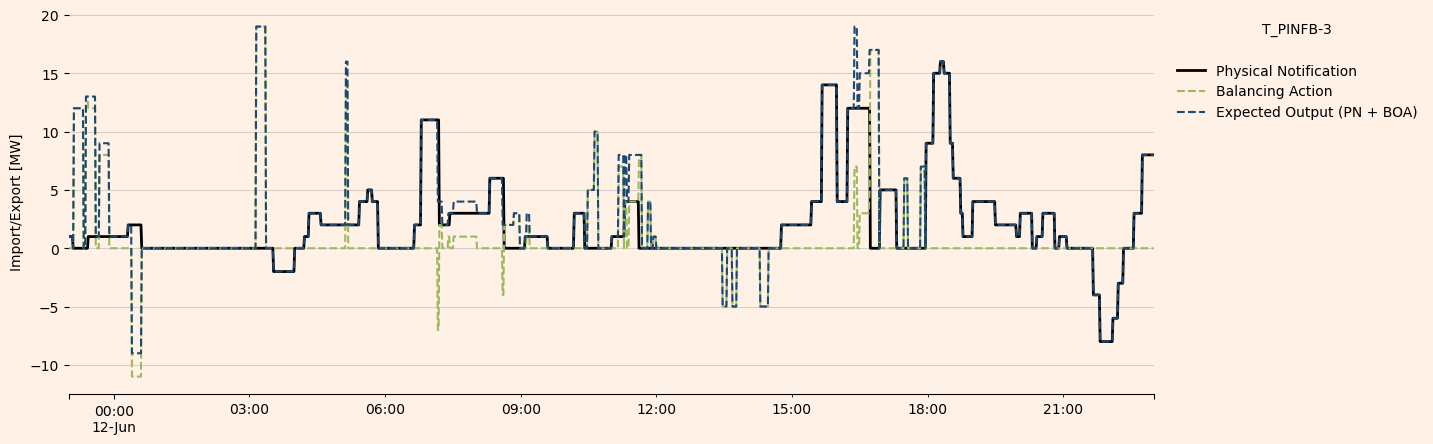

In [206]:
fig, ax = plt.subplots(figsize=(14, 5))

# bm_unit = 'E_CUPAB-1'
bm_unit = 'T_PINFB-3'
# bm_unit = 'T_DRAXX-1'
# bm_unit = 'T_CARR-2'
# bm_unit = 'E_CLAYB-2'

flag_colors = {
    'stor': '#fe7ba8',
    'deemedBo': '#99d3e8',
    'so': '#b63c65',
    'rr': 'orange'
}

start = '2024-06-12'
end = '2024-06-12'

pn_raw = get_pn(bm_unit, start, end)
bm_raw = get_bm(bm_unit, start, end)

pn = process_instruction(pn_raw.reset_index())

bm = process_instruction(pn_raw.reset_index())
bm = process_instruction(bm_raw, start=bm)

balancing = bm - pn

pn.plot(ax=ax, color='k', label='Physical Notification', linewidth=2)
balancing.plot(ax=ax, color='#9eb85f', linestyle='--', linewidth=1.5, label='Balancing Action')
bm.plot(ax=ax, color='#1c4972', linestyle='--', linewidth=1.5, label='Expected Output (PN + BOA)')

flag_status = get_flags(bm_raw)

handles, labels = ax.get_legend_handles_labels()
handles = [plt.Line2D([0], [0], color=background_color, linewidth=1)] + handles
labels = [''] + labels

need_more_labels = False
for col in flag_status.columns:

    if flag_status[col].sum() == 0:
        continue

    (
        flag_status
        .loc[flag_status[col]][col]
        .replace(to_replace=True, value=0)
        .plot(
            ax=ax,
            linestyle='-',
            linewidth=3,
            color=flag_colors[col],
            label=None,
            )
    )
    need_more_labels = True

if need_more_labels:
    handles.append(plt.Line2D([0], [0], color=background_color, linewidth=1))
    handles.append(plt.Line2D([0], [0], color=background_color, linewidth=1))
    labels.append('')
    labels.append('Flags')
    
    for col in flag_status.columns:
        if flag_status[col].sum() == 0:
            continue
    
        handles.append(plt.Line2D([0], [0], color=flag_colors[col], linewidth=3))
        labels.append(col.capitalize())


ax.set_facecolor(background_color)
fig.set_facecolor(background_color)
ax.grid(True, linestyle='-', alpha=0.5, axis='y')
ax.set_axisbelow(True)

ax.legend(
    title=f'{bm_unit}',
    handles=handles,
    labels=labels,
    bbox_to_anchor=(1.01, 1),
    loc='upper left',
    frameon=False,
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_ylabel('Import/Export [MW]')
plt.savefig(f'../imgs/minute_PN__BOA_{bm_unit}.png', bbox_inches='tight', dpi=300)

plt.show()

In [226]:
northern = [
    'E_CUPAB-1',
    'T_PINFB-2',
    '2__PLOND001',
    'E_JAMBB-2',
]

southern = [
    'T_NURSB-1',
    'T_PINFB-2',
    'T_PINFB-3',
    '2__GLOND001',
    # '2__GLOND002',
    # 'T_BUSTB-1',
    # '2__LANGE002',
    # 'T_COWB-1',
    # '2__GSTAT005',
    # 'T_KEMB-1'
]

In [252]:
from tqdm import tqdm

mode = 'north'

start = '2024-03-26'
end = '2024-04-01'

def get_group_actions(bms, start, end):

    total_bm = pd.DataFrame()

    for bm_unit in tqdm(bms):
        
        pn_raw = get_pn(bm_unit, start, end)
        bm_raw = get_bm(bm_unit, start, end)

        pn = process_instruction(pn_raw.reset_index())

        if total_bm.empty:
            total_pn = pd.DataFrame(columns=bms, index=pn.index)
            total_bm = pd.DataFrame(columns=bms, index=pn.index)

        total_pn[bm_unit] = pn

        bm = process_instruction(pn_raw.reset_index())
        bm = process_instruction(bm_raw, start=bm)

        balancing = bm - pn

        total_bm[bm_unit] = balancing
    
    return total_pn, total_bm


south_pn, south_bm = get_group_actions(southern, start, end)
north_pn, north_bm = get_group_actions(northern, start, end)

100%|██████████| 4/4 [00:18<00:00,  4.60s/it]


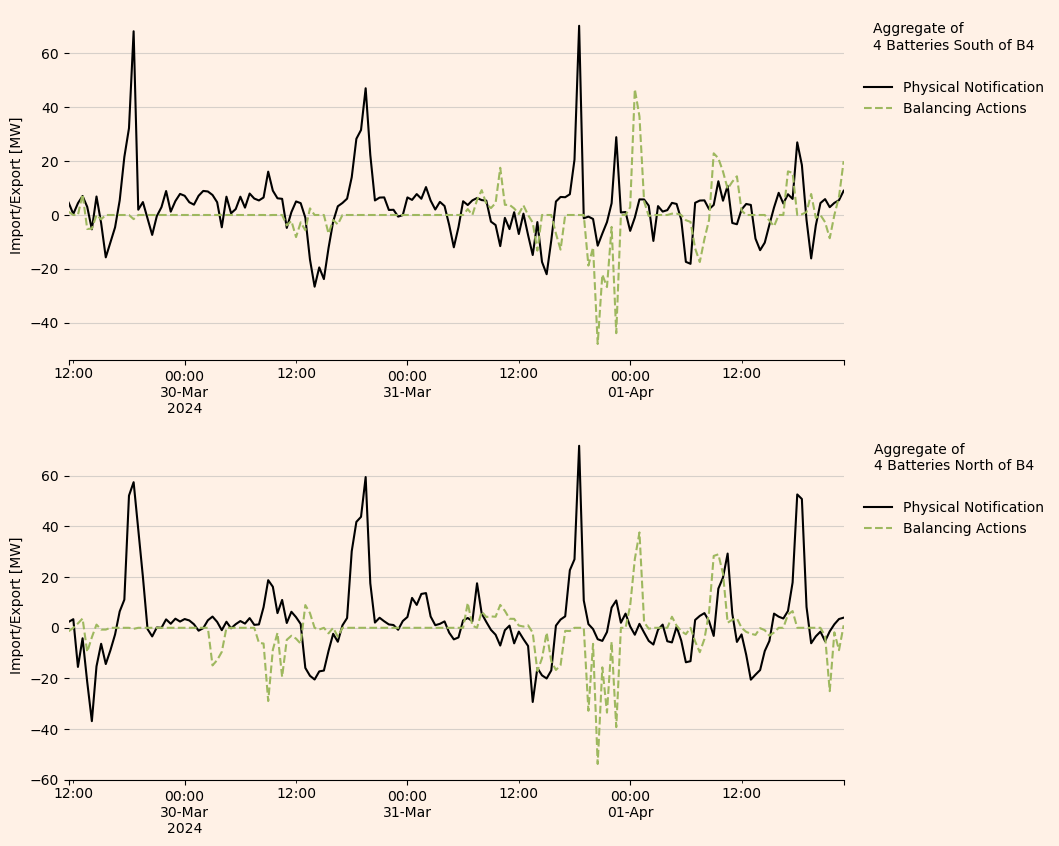

In [253]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

freq = '30min'

for ax, total_pn, total_bm, mode in zip(axs, [south_pn, north_pn], [south_bm, north_bm], ['south', 'north']):

    total_pn.sum(axis=1).iloc[len(total_pn)//2:].resample(freq).mean().plot(ax=ax, color='k', label='Physical Notification', linewidth=1.5)
    total_bm.sum(axis=1).iloc[len(total_pn)//2:].resample(freq).mean().plot(ax=ax, color='#9eb85f', linestyle='--', linewidth=1.5, label='Balancing Actions')

    background_color = '#fff1e6'

    ax.set_facecolor(background_color)
    fig.set_facecolor(background_color)
    ax.grid(True, linestyle='-', alpha=0.5, axis='y')
    ax.set_axisbelow(True)

    handles, labels = ax.get_legend_handles_labels()
    handles = [plt.Line2D([0], [0], color=background_color, linewidth=1)] + handles
    labels = [''] + labels

    ax.legend(
        title=f'Aggregate of \n{len(southern)} Batteries {mode.capitalize()} of B4',
        handles=handles,
        labels=labels,
        bbox_to_anchor=(1.01, 1),
        loc='upper left',
        frameon=False,
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_ylabel('Import/Export [MW]')

plt.show()

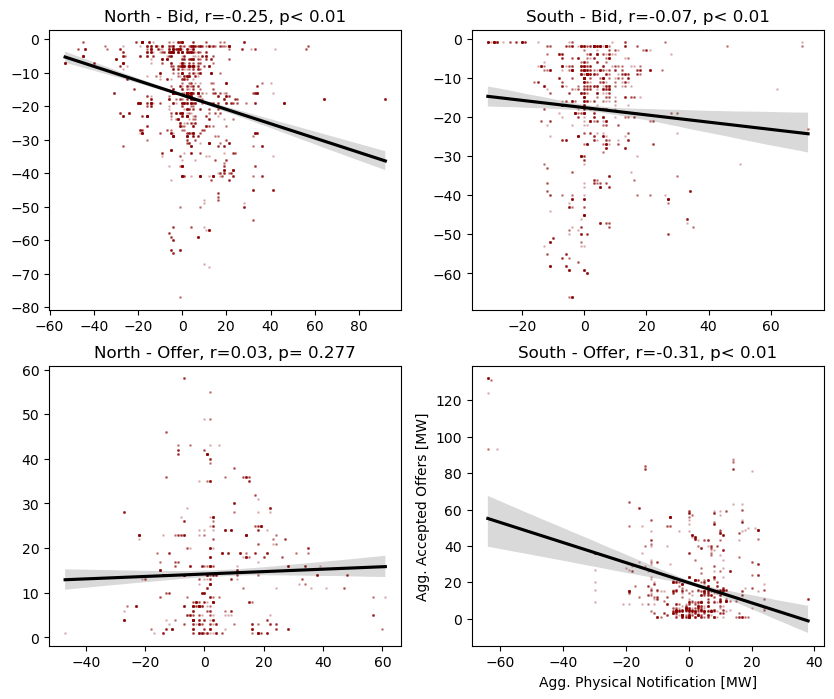

In [254]:
import seaborn as sns
from itertools import product
from scipy.stats import pearsonr


fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for ax, (mode, bm_mode) in zip(axs.T.flatten(), product(['north', 'south'], ['bid', 'offer'])):


    bm_df = globals()[f'{mode}_bm']
    pn_df = globals()[f'{mode}_pn']

    if bm_mode == 'offer':
        mask = bm_df.sum(axis=1) > 0
    else:
        mask = bm_df.sum(axis=1) < 0

    sns.regplot(
        x=pn_df.sum(axis=1)[mask],
        y=bm_df.sum(axis=1)[mask],
        ax=ax,
        color='k',
        scatter_kws={'alpha': 0.2, 's': 1, 'color': 'darkred'},
        )

    r, p = pearsonr(pn_df.sum(axis=1)[mask], bm_df.sum(axis=1)[mask])
    r, p = round(r, 2), round(p, 4)

    if p < 0.01: p = '< 0.01'
    else: p = f'= {p:.3f}'
        
    ax.set_title(f'{mode.capitalize()} - {bm_mode.capitalize()}, r={r}, p{p}')


ax.set_xlabel('Agg. Physical Notification [MW]')
ax.set_ylabel('Agg. Accepted Offers [MW]')

plt.show()
